In [1]:
import pandas as pd
import numpy as np
import math

rng = np.random.default_rng()

In [2]:
boardSize = 50
numberOfAnts = 1
antScanDistance = 1
  # above 1
gamma1 = 0.5
gamma2 = 0.5
neighborhood = (2 * (antScanDistance ) + 1) ** 2
print(neighborhood)

9


In [3]:
data = pd.read_csv(
    "./Audytorium/sdmt1.txt",
    sep='\t',
    header=None,
    names=['depth', 'value1', 'value2']
)

data.insert(0, 'ID', range(0, 0 + len(data)))

spawnPositions = pd.DataFrame(rng.integers(0, boardSize, size=(len(data.index), 2)), columns=list('xy'))

data = pd.concat([data, spawnPositions], axis=1)

data.insert(6, 'isOnTheGround', True)

data.head()

,ID,depth,value1,value2,x,y,isOnTheGround
0,0,"2,6",335,500,18,3,True
1,1,"2,8",390,650,20,1,True
2,2,3,435,750,2,26,True
3,3,"3,2",385,750,15,17,True
4,4,"3,4",150,450,4,32,True


In [4]:
dissimilarityScaleValue1 = data['value1'].max() - data['value1'].min()
dissimilarityScaleValue2 = data['value2'].max() - data['value2'].min()

<AxesSubplot:xlabel='x', ylabel='y'>

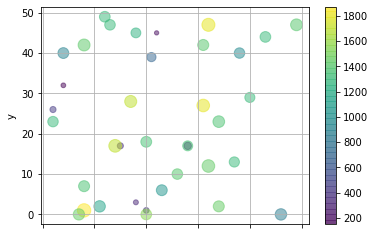

In [5]:
data.plot.scatter(x="x", y="y", s=data["value2"]/20, c=data["value1"], cmap='viridis', alpha=0.5, grid=True)
# s=data["value1"]/20,

In [23]:
class Ant:
    def __init__(self):
        self.x = rng.integers(0, boardSize)
        self.y = rng.integers(0, boardSize)
        self.isCarring = False
        self.carriedSeedId = -1


    def tick(self):
        if (self.isCarring):
            self.move()
        else:
            self.teleport()

        seedId = self.isStandingOnSeed()
        if seedId != -1:
            if not self.isCarring:
                self.pickUpTrial(seedId)
        else:
            if self.isCarring:
                self.dropTrial()

        pass


    def teleport(self):
        targetSeedId = rng.integers(0, len(data.index))
        self.x = data['x'][targetSeedId]
        self.y = data['y'][targetSeedId]


    def move(self):
        # TODO: Needs improvement - ant is generally constantly in the same region 
        deltaX = rng.integers(-1, 2)
        deltaY = rng.integers(-1, 2)

        newX = self.x + deltaX
        if(newX >= 0 and newX < boardSize):
            self.x = newX

        newY = self.y + deltaY
        if(newY >= 0 and newY < boardSize):
            self.y = newY
        pass


    def isStandingOnSeed(self):
        i = 0
        for x, y in zip(data['x'], data['y']):
            if (x == self.x) and (y == self.y):
                if (data['isOnTheGround'][i]):
                    return i
            i += 1
        return -1


    def scanEnvironment(self):
        closeSeeds = []

        i = 0
        for x, y in zip(data['x'], data['y']):
            if (x >= self.x - antScanDistance) and (x <= self.x + antScanDistance):
                if (y >= self.y - antScanDistance) and (y <= self.y + antScanDistance):
                    # distance = math.sqrt((x - self.x)  ** 2 + (y - self.y) ** 2)
                    # if (distance <= antScanDistance):
                    closeSeeds.append(i)
            i += 1

        return closeSeeds


    def calculateLocalSimilarity(self, id):
        closeSeeds = self.scanEnvironment()
        
        sum = 0
        for seed in closeSeeds:
            sum += 1 - (abs(data['value1'][seed] - data['value1'][id]) / dissimilarityScaleValue1)

        localSimilarity = sum / neighborhood
        if (localSimilarity < 0):
            localSimilarity = 0

        # print(localSimilarity)
        
        return localSimilarity

    # Propability
    def pickUpTrial(self, id):
        localSimilarity = self.calculateLocalSimilarity(id)

        propability = (gamma1 / (gamma1 + localSimilarity)) ** 2
        # print(propability)
        if(propability > rng.random()):
            self.pickUp(id)
        pass

    def pickUp(self, id):
        data['isOnTheGround'][id] = False
        self.isCarring = True
        self.carriedSeedId = id
        pass

    # Propability
    def dropTrial(self):
        localSimilarity = self.calculateLocalSimilarity(self.carriedSeedId)

        if(localSimilarity < gamma2):
            propability = localSimilarity
        else:
            propability = 1
        

        if(propability > rng.random()):
            self.drop()
        pass

    def drop(self):
        data['isOnTheGround'][self.carriedSeedId] = True
        data['x'][self.carriedSeedId] = self.x
        data['y'][self.carriedSeedId] = self.y

        self.isCarring = False
        self.carriedSeedId = -1
        pass

ants = []

data['isOnTheGround'] = True

for i in range(0, numberOfAnts):
    ants.append(Ant())

for i in range(0, 10000):
    for ant in ants:
        ant.tick()
        # if((i % 10) == 0):
        #     data.plot.scatter(x="x", y="y",xlim=(0, boardSize), ylim=(0, boardSize), s=30, c=data["value1"], cmap='viridis', alpha=0.5, grid=True)

<AxesSubplot:xlabel='x', ylabel='y'>

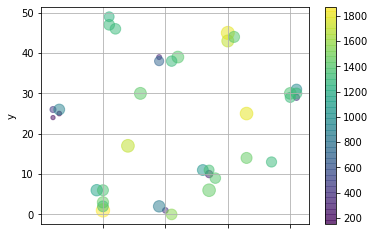

In [24]:
data.plot.scatter(x="x", y="y", s=data["value2"]/20, c=data["value1"], cmap='viridis', alpha=0.5, grid=True)